In [29]:
import numpy as np
import cvxpy as cp
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Math

matplotlib.rcParams.update({
    "text.usetex" : True, 'font.size' : 14
})

np.random.seed(0)

## Задача 1 (5 pts)

В одной из компаний два коллеги Алиса и Боб обсуждают, какую рекламу запустить в новой маркетинговой кампании. 
На выбор предлагается $n$ вариантов. 
У стартапа есть данные о распределении выручки $x_j$, полученной за просмотр каждого объявления $j$. 
Распределение для каждого объявления дискретизировано по $m$ возможным исходам для выручки, $c_1, \ldots ,c_m \in \mathbb{R}$, причем $c_1 < c_2 < \ldots < c_m$. 
Алиса и Боб используют матрицу $P \in \mathbb{R}^{m\times n}$ для описания всех $n$ распределений, причем $\mathbb{P}(x_j = c_i) = P_{ij}$.

Алиса выступает за создание новой системы, которая будет случайным образом показывать посетителям различные объявления, причем каждое объявление $j$ будет появляться в течение доли $\theta_j$ времени. 
Боб не согласен и считает, что достаточно старой системы, которая показывает одно и то же объявление каждый раз.
При рандомизированной политике доход за просмотр $x_{mix}$ соответствует дискретному распределению 
$p = P \theta $, 
где $\theta \in \mathbb{R}^n_{++}$, $\sum_{i=1}^n \theta_i = 1$, а $\mathbb{P}(x_{mix} = c_i) = p_i$. 

Стартап потеряет деньги на кампании, если $x_{mix} < 0$, и будет считать кампанию успешной, если $x_{mix} > L$. Цель Алисы и Боба - максимизировать вероятность успешной кампании, обеспечив при этом вероятность убытков не более $\beta$.
Использую приведённые ниже данные определите какая стратегия лучше (случайная или детерминированная)?

Покажите, как формализовать данную задачу в форме задачи выпуклой оптимизации и решите её с помощью cvxpy, используя данные ниже.


In [30]:
n = 4 
m = 5

c = np.array([-2, -1, 0, 1, 2])

P = np.array([
  [.1, 0.4, 0, 0, .5],
  [.3, 0, 0, 0, .7],
  [.3, 0, 0, .4, .3],
  [0, 0, .75, .25, 0],
]).T

beta = 0.1

L = 0

In [31]:
def plot_theta_p(title: str, theta):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(title)
    ax[0].bar([fr'$\theta_{i}$' for i in range(n)], theta)
    ax[0].set_yticks(np.linspace(0, 1, 11))
    ax[0].minorticks_on()
    ax[0].tick_params(axis='x', which='minor', bottom=False)
    ax[0].grid(True, axis='y', lw=1, which='major')
    ax[0].grid(True, axis='y', alpha=0.3, lw=0.5, which='minor')
    ax[0].set_axisbelow(True)

    ax[1].bar([fr'$p_{i}$' for i in range(m)], P @ theta)
    ax[1].set_yticks(np.linspace(0, 1, 11))
    ax[1].minorticks_on()
    ax[1].tick_params(axis='x', which='minor', bottom=False)
    ax[1].grid(True, axis='y', lw=1, which='major')
    ax[1].grid(True, axis='y', alpha=0.3, lw=0.5, which='minor')
    ax[1].set_axisbelow(True)
    fig.tight_layout()

### Детерминированный подход

В данной задаче выбирается только один вариант рекламы (вектор $\theta$ имеет ровно одну единицу, остальные элементы равны нулю).

$\begin{aligned}
& \max_{\theta} & & \mathbf{1}^\mathsf{T}_{c_i > L} \mathbf{P} \theta \\
& \text{s.t. } & & \theta \geqslant 0 \\
&&&            \mathbf{1}^\mathsf{T} \theta = 1 \\
&&&            \Vert\theta\Vert_0 = 1 \\
&&&            \mathbf{1}^\mathsf{T}_{c_i < 0} \mathbf{P} \theta \leqslant \beta
\end{aligned}$
 
Здесь было введены обозначения $\mathbf{1}_{c_i > L},\,\mathbf{1}_{c_i < 0} \in \mathbb{R}^{n}$ - векторы, элементы которых равны 0 или 1, на позиции $i$ находится 1, если верно условие $c_i > L$ и $c_i < 0$ соответсвенно, иначе 0. Из-за условия $\Vert\theta\Vert_0 = 1$ данная задача не является выпуклой, поэтому решим ее перебором, то есть проверим $n$ вариантов выбора рекламы, при котором будет показываться только выбраный вариант (детерминированная стратегия).

In [32]:
theta = np.zeros(n)

success_prob_theta_series = np.zeros_like(theta)
feasibility_theta_series = np.full_like(theta, fill_value=False, dtype=np.bool)
loss_prob_theta_series = np.zeros_like(theta)

for i in range(n):
    theta.fill(0)
    theta[i] = 1
    
    p = P @ theta
    
    success_prob = np.sum(p * (c > L))
    loss_prob = np.sum(p * (c < 0))
    
    # other constraints are satisfied automatically
    constraints = np.array([
        loss_prob <= beta
    ])
    
    feasibility_theta_series[i] = np.all(constraints)
    loss_prob_theta_series[i] = loss_prob
    success_prob_theta_series[i] = success_prob

success_prob_theta_series[~feasibility_theta_series] = -np.inf

opt_theta_idx = np.argmax(success_prob_theta_series).item()
opt_success_prob = success_prob_theta_series[opt_theta_idx].item()
opt_loss_prob = loss_prob_theta_series[opt_theta_idx]

opt_theta = np.zeros_like(theta)
opt_theta[opt_theta_idx] = 1.

print(f"[Deterministic approach]\nOptimal theta: {opt_theta}\nMaximum success probability: {opt_success_prob}\nProbability of loss: {opt_loss_prob}")

[Deterministic approach]
Optimal theta: [0. 0. 0. 1.]
Maximum success probability: 0.25
Probability of loss: 0.0


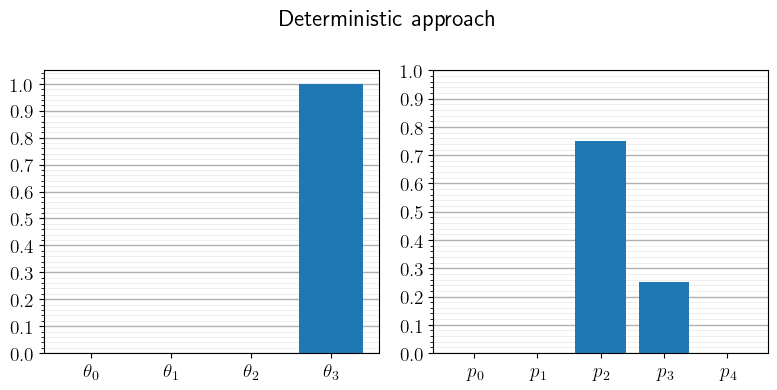

In [33]:
plot_theta_p('Deterministic approach', opt_theta)

### Рандомизированный подход

$\begin{aligned}
&  \max_{\theta} & & \mathbf{1}^\mathsf{T}_{c_i > L} \mathbf{P} \theta \\
& \text{ s.t.} & & \theta \geqslant 0 \\
&&&            \mathbf{1}^\mathsf{T} \theta = 1 \\
&&&            \mathbf{1}^\mathsf{T}_{c_i < 0} \mathbf{P} \theta \leqslant \beta
\end{aligned}$

Даннная задача является выпуклой, так как целевая функция является линейной по $\theta$, первое ограничение задает выпуклое множество $\mathbb{R}^n_+$, второе является аффинным ограничием (линейное уравнение), третье - аффинное неравенство. Таким образом, данная задача является выпуклой.

In [34]:
theta = cp.Variable(n, pos=True)
p = P @ theta

success_prob = cp.sum(cp.multiply(p, c > L))
loss_prob = cp.sum(cp.multiply(p, c < 0))

constraints = [
    loss_prob <= beta,
    theta >= 0,
    cp.sum(theta) == 1
]

objective = cp.Maximize(success_prob)
problem = cp.Problem(objective, constraints)

_ = problem.solve(verbose=False)

In [35]:
print(f"[Randomized approach]\nOptimal theta: {theta.value}\nMaximum success probability: {success_prob.value:.5f}\nProbability of loss: {loss_prob.value:.5f}")

[Randomized approach]
Optimal theta: [4.97493787e-09 1.66666663e-01 1.66666663e-01 6.66666668e-01]
Maximum success probability: 0.40000
Probability of loss: 0.10000


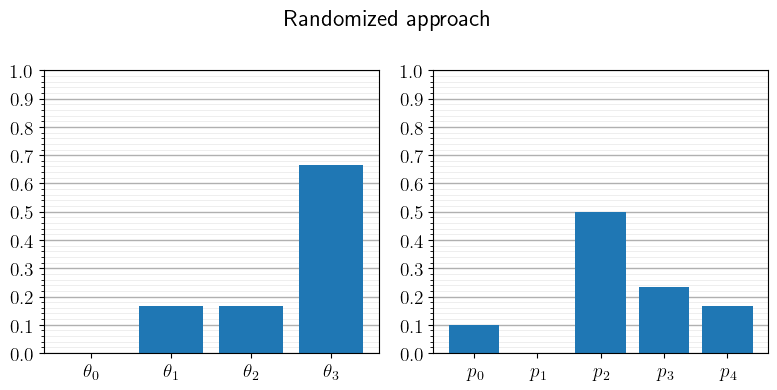

In [36]:
plot_theta_p('Randomized approach', theta.value)

Получаем, что для выбранных параметров рандомизированная стратегия обечпечивает большую вероятность успешной компании. Заметим, что ограничения детерминированной задачи влекут ограничения рандомизированной (то есть любое допустимое $\theta$ в первой задаче будет также допустимым и для второй задачи). Поэтому вторая задача на допустимом множестве будет иметь решение не хуже, чем первая.

## Задача 2. (12 pts)
### Задача об изоморфизме графов

Пусть даны два графа $G_A$ и $G_B$ с матрицами смежности $A$ и $B$ соответственно. [Задача об изоморфизме графов](https://en.wikipedia.org/wiki/Graph_isomorphism_problem) состоит в поиске такой матрицы перестановки $P$, что выполнено

$$
PAP^{\top} = B.
$$

На данный момент неизвестно является ли эта задача NP-полной или лежит в классе P.

1) (4 pts) запишите ограничения на искомую матрицу $P$ и покажите, что задача об изоморфизме графа может быть записана как бинарная задачу линейного программирования, то есть как задача линейного программирования, в которой элементами решения могут быть только 0 и 1. (**Hint**: подумайте как задачу о существовании некоторого элемента в множестве записать в виде задачи оптимизации)

2) (4 pts) далее рассмотрите релаксацию поставленной задачи, в которой элементы решения могут принимать значения в отрезке $[0, 1]$.
Покажите, что подобная релаксация делает задачу выпуклой. 
Если решение такой задачи не нашлось, то это значит, что графы не изоморфны. Если решение нашлось и элементы решения только 0 или 1, то найдена искомая перестановка. Конечно, такое случается достаточно редко. Чтобы форсировать бинарность элементов решения, к целевой функции исходной задачи можно добавить слагаемое вида $\langle W, P \rangle$, где $W$ некоторая случайная матрица, например с элементами из $\mathcal{N}(0, 1)$ (возможно использование других распределений). Добавление такого слагаемого не повлияет на решение вопроса существования перестановки. 

3) (4 pts) Убедитесь, что графы с матрицами смежности, заданными [тут](https://web.stanford.edu/~boyd/cvxbook/cvxbook_additional_exercises/graph_isomorphism_data.py), являются изоморфными с помощью пакета cvxpy. Для поиска матрицы перестановки, возможно, необходимо решать несколько задач линейного программирования для разных матриц $W$. Также рассмотрите несколько распределений для генерации матрицы $W$. Убедитесь, что найденная матрица действительно является матрицей перестановки. Для проверки бинарности элементов можно отслеживать величину $\max_{(i, j)} P_{ij}(1 - P_{ij})$. После обнаружения матрицы перестановки выведите результат умножения матрицы $P^*$ на вектор $[1, 2, \ldots, n]$ для демонстрации того, как надо переставить вершины исходного графа.

### Решение

1. $P$ является матрицей перестановки тогда и только тогда, когда в каждом столбце и в каждой строке стоит ровно одна единица, а все остальные элементы матрицы равны нулю. Данное условие можно записать в следующей форме:

    $ P_{ij}\in\{0,1\}\;\forall i,j\;,\quad P \mathbf{1} = \mathbf{1},\quad P^\mathsf{T} \mathbf{1} = \mathbf{1}.$

    Заметим, что матрица перестановки является ортогональной, то есть $P^{-1} = P^\mathsf{T}$. Значит, условие $PAP^\mathsf{T} = B$ можно переписать как $P A = B P$. Данная задача является так называемой задачей о допустимости, можем добавить фиктивную целевую функцию и получить бинарную задачу линейного программирования (есть дискретное условие на элементы $P$):

    $\begin{aligned}
    &  \min_{P} & & 0 \\
    & \text{ s.t.} & & P \mathbf{1} = \mathbf{1} \\
    &&&            P^\mathsf{T} \mathbf{1} = \mathbf{1} \\
    &&&            P A = B P \\
    &&&            P_{ij}\in\{0,1\},\;\forall i,j
    \end{aligned}$

2. Рассмотрим релаксацию поставленной бинарной задачи линейного программирования: заменим дискретное условие $P_{ij}\in\{0,1\}$ на $P_{ij}\in[0;1]$. Условие $P_{ij}\in[0;1]$ можно ослабить до $P_{ij} \geqslant 0$, так как в этом случае верхняя граница будет следовать из оставшихся ограничений. Выпишем эту задачу:

    $\begin{aligned}
    &  \min_{P} & & 0 \\
    & \text{ s.t.} & & P \mathbf{1} = \mathbf{1} \\
    &&&            P^\mathsf{T} \mathbf{1} = \mathbf{1} \\
    &&&            P A = B P \\
    &&&            P_{ij} \geqslant 0,\;\forall i,j
    \end{aligned}$

    Для форсирования бинарности элементов матрицы рассмотрим целевую функцию вида $\text{tr}(W^\mathsf{T}P)$, где $W$ - некоторая случайная матрица, будут рассмотрены варианты $W_{ij}\sim \text{iid }\mathcal{N}(0, 1)$ и $W_{ij}\sim \text{iid }\mathcal{U}([-1;1])$. Изменение целевой функции не повлияет на существование перестановки (то есть на решение задачи о допустимости), но решение серии таких задач с разными $W$ может привести к нахождению матрицы $P$, являющейся матрицей перестановки (а не произвольным решением релаксированной задачи). Полученная задача линейного программирования имеет вид: 

    $\begin{aligned}
    &  \min_{P} & & \text{tr}(W^\mathsf{T}P) \\
    & \text{ s.t.} & & P \mathbf{1} = \mathbf{1} \\
    &&&            P^\mathsf{T} \mathbf{1} = \mathbf{1} \\
    &&&            P A = B P \\
    &&&            P_{ij} \geqslant 0,\;\forall i,j
    \end{aligned}$

In [37]:
with np.load('matrices.npz') as data:
    A = data['A']
    B = data['B']

In [38]:
max_repeats = 100
perm_check_eps = 1e-10
    
n = A.shape[0]

U = np.ones(n)

W = cp.Parameter((n, n))

P = cp.Variable((n, n), pos=True)
objective = cp.Minimize(cp.trace(W.T @ P))
constraints = [
    P @ U == U,
    P.T @ U == U,
    P @ A == B @ P,
    0 <= P,
    P <= 1
]

problem = cp.Problem(objective, constraints)

# series of experiments for N(0, 1)
# Pn - solution of problem with W from normal distribution
for i in range(max_repeats):
    W.value = np.random.randn(n, n)
    _ = problem.solve(verbose=False)
    Pn = P.value
    perm_check_n = np.max(Pn * (1 - Pn))
    if perm_check_n < perm_check_eps:
        break
    
# series of experiments for U([-1, 1]) 
# Pn - solution of problem with W from uniform distribution
for i in range(max_repeats):
    W.value = np.random.uniform(low=-1, high=1, size=(n, n))
    _ = problem.solve(verbose=False)
    Pu = P.value
    perm_check_u = np.max(Pu * (1 - Pu))
    if perm_check_u < perm_check_eps:
        break

In [39]:
display(Math(fr'$\text{{Normal: }}\max_{{(i, j)}} P_{{ij}}(1 - P_{{ij}})={perm_check_n:.1e}$'))
display(Math(fr'$\text{{Uniform: }}\max_{{(i, j)}} P_{{ij}}(1 - P_{{ij}})={perm_check_u:.1e}$'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [40]:
Pn = np.round(np.abs(Pn)).astype(np.int8)
Pu = np.round(np.abs(Pu)).astype(np.int8)

np.allclose(Pn, Pu)  # permutation matrix might be not unique

True

In [41]:
graphs_isom_n = np.all(Pn @ A @ Pn.T == B).item()
display(Math(fr'$\text{{Normal: }}PAP^\mathsf{{T}} = B$' if graphs_isom_n else fr'$\text{{Normal: }}PAP^\mathsf{{T}} \neq B$'))

graphs_isom_u = np.all(Pn @ A @ Pn.T == B).item()
display(Math(fr'$\text{{Uniform: }}PAP^\mathsf{{T}} = B$' if graphs_isom_u else fr'$\text{{Uniform: }}PAP^\mathsf{{T}} \neq B$'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [42]:
init_order = np.arange(1, n + 1)
perm_n = Pn @ init_order
display(Math(fr"\text{{Normal: }}"), Math(fr'\sigma = \begin{{pmatrix}} {'&'.join(list(map(str, init_order)))} \\ {"&".join(list(map(str, perm_n)))} \end{{pmatrix}}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [43]:
perm_u = Pu @ init_order
display(Math(fr"\text{{Uniform: }}"), Math(fr'\sigma = \begin{{pmatrix}} {'&'.join(list(map(str, init_order)))} \\ {"&".join(list(map(str, perm_u)))} \end{{pmatrix}}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Задача 3 (15 pts)

Онкологический пациент получает дозу облучения $d_t \in \mathbb{R}_+$ в периоды времени $t = 1, \dots, T - 1$, с целью уменьшить опухоль до некоторого заданного целевого размера, при этом минимизируя ущерб здоровью пациента. 
Мы можем выбирать дозы $d_t$ с учетом ограничения $d_t \leq dmax$, где $dmax$ - заданная максимальная доза. 
Пусть $S_t \in \mathbb{R}_+$ обозначает размер опухоли в период $t$. 
Размер опухоли изменяется следующим образом

$$ S_{t+1} = \alpha e^{-\beta d_t} S_t, \quad t=1,\dots,T -1,$$

где $\alpha > 1$ - скорость роста опухоли за период при отсутствии облучения, а $\beta > 0$ - известная константа. 
(Поскольку $d_t \geq 0$ и $\beta > 0$, мы видим, что излучение, примененное в один период, уменьшает опухоль в следующий период). 
Начальный размер опухоли $S_1$ задан. 
Задача состоит в том, чтобы достичь $S_T \leq S_{tar}$, где $S_{tar}$ - целевой конечный размер опухоли.

Пусть $H_t \in \mathbb{R}_+$ обозначает некоторую меру ущерба, нанесенного здоровью пациента в результате лучевой терапии. 
Она изменяется следующим образом

$$ H_{t+1} = \gamma e^{\delta d_t}H_t, \quad t=1,...,T -1,$$

где $\gamma \in (0, 1]$ – скорость восстановления здоровья за период без облучения, а $\delta > 0$ – известная константа. 
(Поскольку $d_t \geq 0$ и $\delta > 0$, мы видим, что излучение, примененное в один период, увеличивает повреждения в следующий период). 
Задано начальное повреждение $H_1$.
Задача состоит в том, чтобы найти серию доз $d_1, \dots, d_{T -1}$, которая удовлетворяет ограничениям, описанным выше, и минимизирует максимальный ущерб $H_{max} = \max_{t=1,\dots,T} H_t$

- (5 pts) Объясните, как решить эту задачу с помощью выпуклой оптимизации. Если вы меняете переменные или формируете релаксацию, вы должны объяснить и обосновать это.

- (10 pts) Решите задачу с помощью пакета cvxpy при $T = 20$ и $dmax =1.2$, $\alpha=1.05$, $\beta=0.6$, $\gamma=0.9$, $\delta=0.3$, $S_1 =1$, $S_{tar} = 0.01$, $H_1 =1$.
Сообщите оптимальное значение целевой функции, т.е. максимальный ущерб. 
Постройте график зависимости дозы $d_t$, ущерба $H_t$ и размера опухоли $S_t$ от $t$ для оптимального плана облучения. 
Постройте аналогичный график для случая, когда лечение не проводится, т.е. $d_t =0$ для $t=1, \dots,T-1$.

### Решение

Запишем оптимизационную задачу, которая напрямую формируется из условия:

$\begin{aligned}
& \min_{(d_t)_{t=1}^{T-1}} & & \max_{t\in\overline{1,T}} H_t \\
& \text{ s.t.} & & H_{t+1} = \gamma^{t} e^{\delta \sum_{k=1}^{t}d_k} H_1,\; t\in\overline{1,T-1} \\
&&&            \alpha^{T-1} e^{-\beta \sum_{k=1}^{T-1}d_k} S_1 \leqslant S_\text{tar}  \\
&&&            0 \leqslant d_t \leqslant d_\text{max},\; t\in\overline{1,T-1} \ \\
\end{aligned}$

Получили задачу минимизации с выпуклыми ограничениями (аффинные функции в экспонентах в неравенстве на размер опухоли и в определениях вреда, неравенства на $d_t$ задают выпуклое множество) и выпуклой целевой функцией (как максимум среди выпуклых функций). Преобразуем задачу в терминах надграфика, введя вспомогательную переменную $y$:

$\begin{aligned}
&&& \min_{y, (d_t)_{t=1}^{T-1}} y \\
& \text{ s.t.} && H_1 \leqslant y \\
&&&               \gamma^{t-1} e^{\delta \sum_{k=1}^{t-1}d_k} H_1 \leqslant y,\; t\in\overline{2,T} \\
&&&            \alpha^{T-1} e^{-\beta \sum_{k=1}^{T-1}d_k} S_1 \leqslant S_\text{tar}  \\
&&&            0 \leqslant d_t \leqslant d_\text{max},\; t\in\overline{1,T-1} \ \\
\end{aligned}$

Заметим, что из условия и начальных данных следует, что $H_t, S_t > 0$. Дополнительно упростим задачу, устранив нелинейности, прологарифмировав неравентва на $H_t$ и $S_t$, превратив их таким образом в линейные (логарифм монотонно возрастает на области определения):

$\begin{aligned}
&&& \min_{z, (d_t)_{t=1}^{T-1}} z \\
& \text{ s.t.} && \ln H_1 \leqslant z \\
&&&               (t-1) \ln(\gamma)  + \delta \textstyle\sum_{k=1}^{t-1}d_k + \ln(H_1) \leqslant z,\; t\in\overline{2,T} \\
&&&            (T-1) \ln(\alpha) -\beta \textstyle\sum_{k=1}^{T-1}d_k + \ln(S_1) \leqslant \ln(S_\text{tar})  \\
&&&            0 \leqslant d_t \leqslant d_\text{max},\; t\in\overline{1,T-1} \ \\
\end{aligned}$

Здесь ведено обозначение $z = \ln(y)$. Таким образом, мы перешли к задаче линейного программирования относительно $(z,d_1,...,d_{T-1})\in\mathbb{R}^T$, которую можно решить эффективно.

In [44]:
T = 20
d_max = 1.2
alpha = 1.05
beta = 0.6
gamma = 0.9
delta = 0.3
S_1 = 1
S_tar = 0.01
H_1 = 1

log_alpha = np.log(alpha)
log_gamma = np.log(gamma)

d = cp.Variable(T - 1, pos=True)  # doses to optimize (d1, ..., dT-1)
log_H = cp.Variable(T)            # logarithm of damage (H1, ..., HT)
z = cp.Variable()                 # maximum damage (will be minimized) 

objective = cp.Minimize(z)

constraints = [log_H[0] == np.log(H_1)]
for t in range(T - 1):
    constraints.extend([
        log_H[t + 1] == (t + 1) * log_gamma + delta * cp.sum(d[0:t+1]) + log_H[0],
        cp.exp(log_H[t]) <= z
    ])

constraints.extend([
    cp.exp((T - 1) * log_alpha - beta * cp.sum(d) + np.log(S_1)) <= S_tar,
    cp.exp(log_H[T - 1]) <= z,
    d >= 0,
    d <= d_max
])

problem = cp.Problem(objective, constraints)

_ = problem.solve(verbose=False)

In [45]:
d_opt = d.value
S_opt = np.array([alpha**t * np.exp(-beta * np.sum(d_opt[:t])) * S_1 for t in range(T)])
H_opt = np.exp(log_H.value)
H_max_opt = objective.value

In [46]:
display(Math(fr'$\min_{{(d_t)_{{t=1}}^{{T-1}}}}\max_{{t\in\overline{{1, T}}}} H_t = {H_max_opt:.3f}$'))

<IPython.core.display.Math object>

In [47]:
S_no_treatment = np.array([alpha**t * S_1 for t in range(T)])
H_no_treatment = np.array([gamma**t * H_1 for t in range(T)])

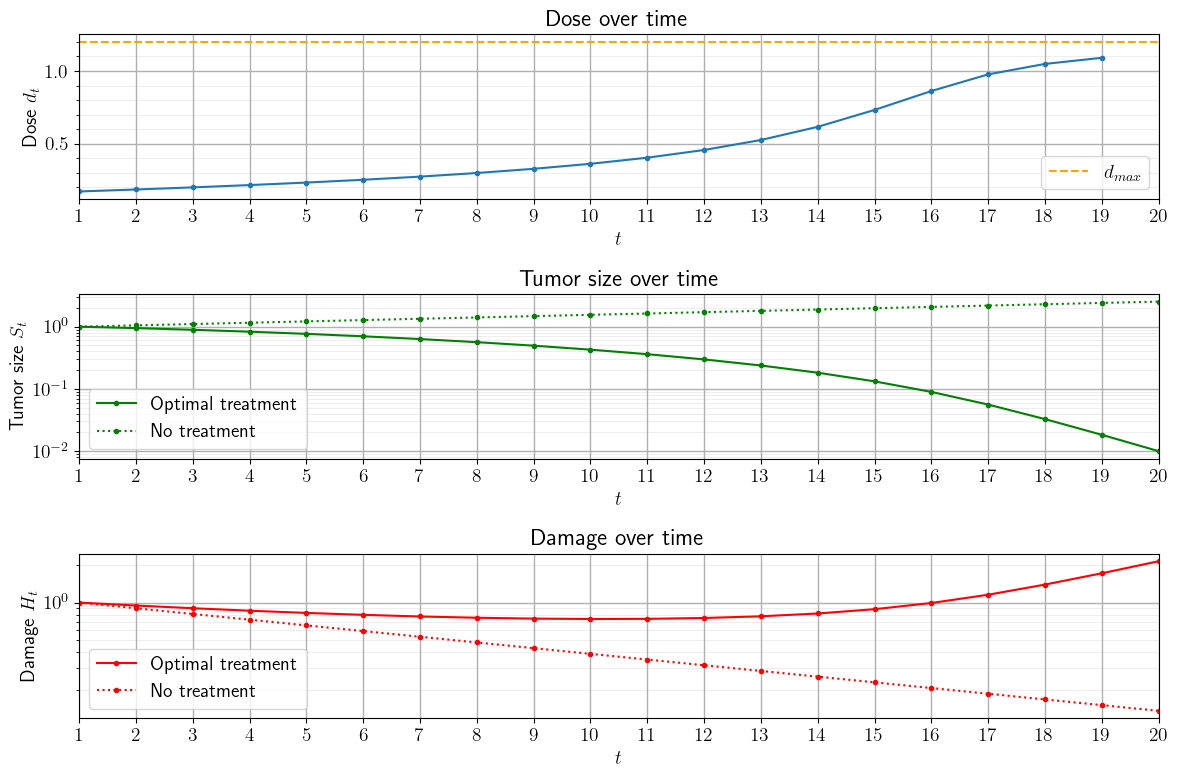

In [48]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8), dpi=100)

ax[0].plot(range(1, T), d_opt, marker='.')
ax[0].hlines(y=d_max, xmin=1, xmax=T, color='orange', ls='--', label='$d_{max}$')
ax[0].set_xticks(np.linspace(1, T, T))
ax[0].set_xlim((1, T))
ax[0].set_xlabel("$t$")
ax[0].set_ylabel("Dose $d_t$")
ax[0].set_title("Dose over time")
ax[0].minorticks_on()
ax[0].tick_params(axis='x', which='minor', bottom=False)
ax[0].grid(True, axis='x', lw=1, which='major')
ax[0].grid(True, axis='y', lw=1, which='major')
ax[0].grid(True, axis='y', alpha=0.3, lw=0.5, which='minor')
ax[0].legend(loc='lower right')

ax[1].semilogy(range(1, T + 1), S_opt, marker='.', color='g', label='Optimal treatment')
ax[1].semilogy(range(1, T + 1), S_no_treatment, marker='.', ls=':', color='g', label='No treatment')
ax[1].set_xticks(np.linspace(1, T, T))
ax[1].set_xlim((1, T))
ax[1].set_xlabel("$t$")
ax[1].set_ylabel("Tumor size $S_t$")
ax[1].set_title("Tumor size over time")
ax[1].minorticks_on()
ax[1].legend()
ax[1].tick_params(axis='x', which='minor', bottom=False)
ax[1].grid(True, axis='x', lw=1, which='major')
ax[1].grid(True, axis='y', lw=1, which='major')
ax[1].grid(True, axis='y', alpha=0.3, lw=0.5, which='minor')

ax[2].plot(range(1, T + 1), H_opt, marker='.', color='r', label='Optimal treatment')
ax[2].semilogy(range(1, T + 1), H_no_treatment, marker='.', ls=':', color='r', label='No treatment')
ax[2].set_xticks(np.linspace(1, T, T))
ax[2].set_xlim((1, T))
ax[2].set_xlabel("$t$")
ax[2].set_ylabel("Damage $H_t$")
ax[2].set_title("Damage over time")
ax[2].minorticks_on()
ax[2].legend()
ax[2].tick_params(axis='x', which='minor', bottom=False)
ax[2].grid(True, axis='x', lw=1, which='major')
ax[2].grid(True, axis='y', lw=1, which='major')
ax[2].grid(True, axis='y', alpha=0.3, lw=0.5, which='minor')

fig.tight_layout()